# iq2df testing
Vance Wheeler Apr 18 2023

Testing the methods developed and stored as a module in iq2df.py for calculating df/f using the sweep reduc and timestream data files from the roach output. Mostly moving toward my 335 project analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',size=14)

import iq2df

import importlib

In [20]:
importlib.reload(iq2df)

<module 'iq2df' from 'C:\\Users\\wheel\\OneDrive\\Documents\\335 Research\\local_analysis\\iq2df.py'>

## Following block of cells used to convert data to df/f
Testing the use of each part individually, and used to process data for the report since I didn't have time to polish the process at all.

In [4]:
# Commented to avoid overwrite.
path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/converted_mar_2023/20230315_224543_sweep_reduc.npz"
path_data = "C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/converted_mar_2023/20230315_230123.npz"

#path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/from_tyler_Vance_pol_data/20221221_193904_sweep_reduc.npy"
#path_srd = "C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/converted/20221221_194114__20221221_193904_sweep_reduc.npz"
#path_data = "C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/from_tyler_Vance_pol_data/20221221_201944.npy"

#folder = 'C:/Users/wheel/OneDrive/Documents/335 Research/data_apr_4_2023/ft85_dfof/'
folder = 'C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/ft84_dfof/'
#folder = 'C:/Users/wheel/OneDrive/Documents/335 Research/data_dec_21_2022/ft47_dfof/'

In [12]:
# sweep file side
kidno,freq,sw_iq_in,refreq = iq2df.read_sweep(path_srd)

slope = iq2df.cable_fit(freq,sw_iq_in)
sw_iq = iq2df.circularize(freq,sw_iq_in,slope)
center = iq2df.get_center_simple(sw_iq)
sw_iq = iq2df.trans_rot(sw_iq,center)

interp = iq2df.get_interp(freq,sw_iq)

param_filname = folder+(path_srd.split('/')[-1]).split('_reduc')[0]+'_dfof_params.npz'

print(param_filname)

iq2df.save_params(param_filname,kidno,slope,center,refreq,interp)

C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/ft84_dfof/20230313_223551_sweep_dfof_params.npz


In [7]:
print(kidno)

['K013' 'K014' 'K015' 'K016' 'K017' 'K018' 'K019' 'K020']


In [27]:
# To use param file without re running above, run this cell:
param_filname = folder+(path_srd.split('/')[-1]).split('_reduc')[0]+'_dfof_params.npz'
print(param_filname)

C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/ft84_dfof/20230315_224543_sweep_dfof_params.npz


In [28]:
# timestream file side

kidno_sw,slope,center,refreq_sw,interp = iq2df.read_params(param_filname)

kidno,refreq,time,ts_iq = iq2df.read_timestream(path_data) # both freq from ts and sweep should match, thats the only
# reason to get it from two sources, to check. If not, redundant.

iq = iq2df.transform(refreq,ts_iq,slope,center)

dfof = iq2df.get_dfof(iq,refreq,interp)

dfof_filname = folder+(path_data.split('/')[-1]).split('.')[0]+'_dfof.npz'

iq2df.save_dfof(dfof_filname,kidno,time,dfof)

## Testing the combined methods

In [14]:
path_param = iq2df.create_paramfile(path_srd,folder,return_path=True)
print(path_param)

In [21]:
path_dfof = iq2df.create_dfoffile(path_data,path_param,folder,return_path=True)
print(path_dfof)

C:/Users/wheel/OneDrive/Documents/335 Research/data_mar_13_2023/ft84_dfof/20230315_230123_dfof.npz


## Reading and plotting df/f

In [22]:
#dfof_dat = np.load(folder+'20230404_230333_dfof.npz')
#dfof_dat = np.load(folder+'20230404_214138_dfof.npz')

dfof_dat = np.load(path_dfof)

In [23]:
t = dfof_dat['time'] - dfof_dat['time'][0] # offset time to start at 0

IndexError: index 8 is out of bounds for axis 0 with size 8

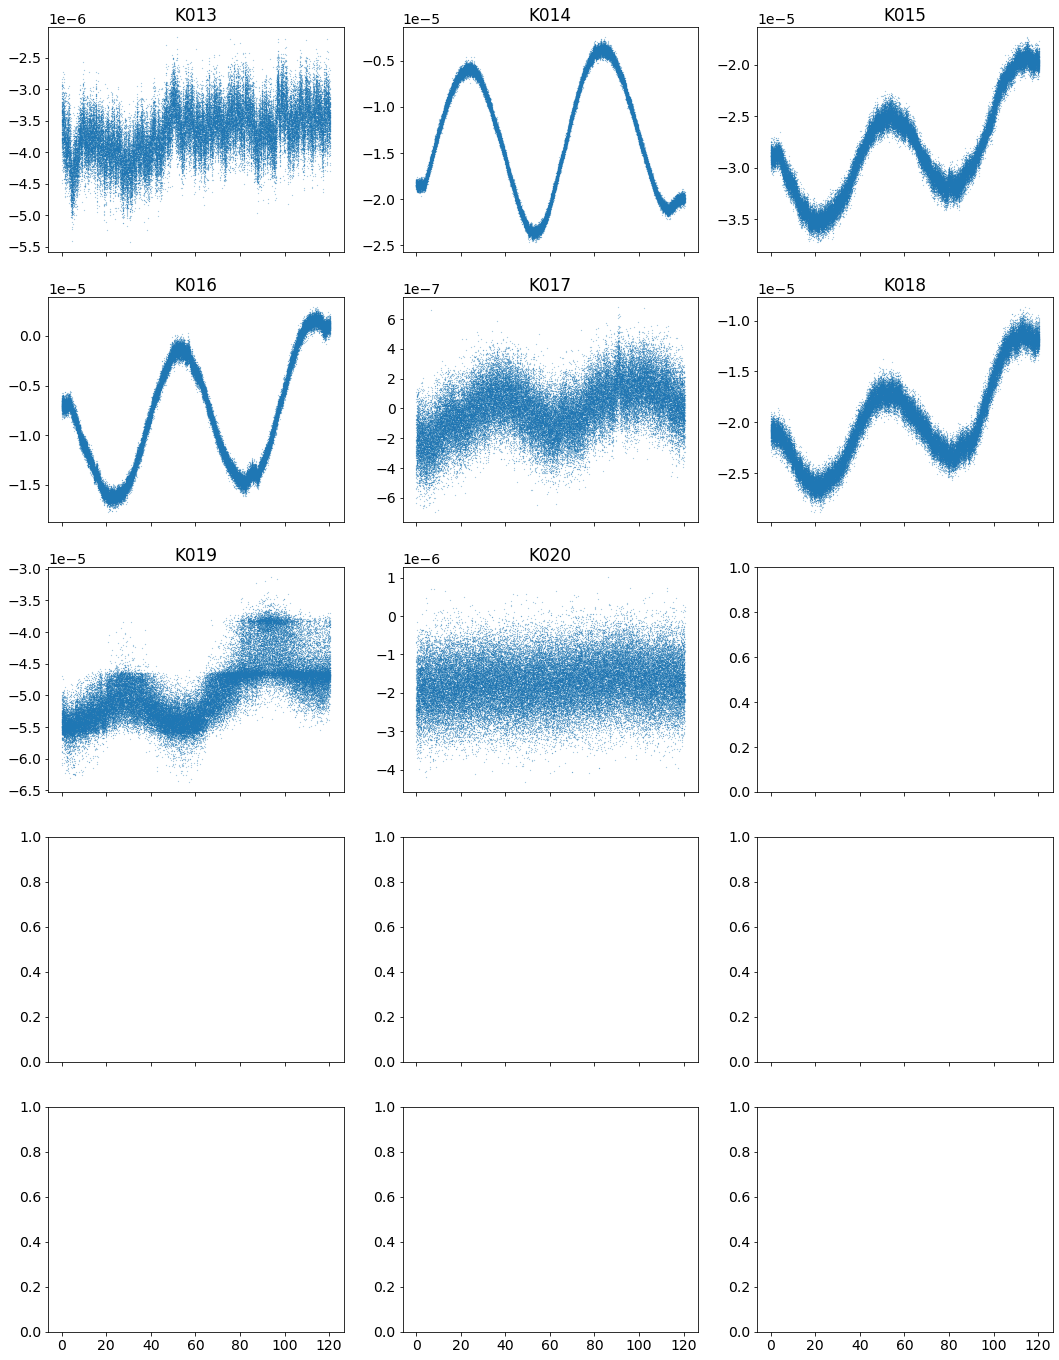

In [24]:
# kept as reference to make a plot
row,col = 5,3

fig,axs = plt.subplots(row,col,figsize=(18,24),sharex=True)

for i in range(len(axs)):
    for j in range(len(axs[0])):
        if not (i==4 and j>=1):
            k = col*i + j
            
            # plots
            axs[i,j].plot(t,dfof_dat['dfof'][k],'.',markersize=.3) # data
            axs[i,j].set_title(dfof_dat['kids'][k])

for ax in axs[-1,:]:
    ax.set_xlabel('time [s]')
for ax in axs[:,0]:
    ax.set_ylabel('df/f')
    
plt.tight_layout()

plt.show()

## Next Steps

So everything I've written works individually, but needs a few more parts.

* I haven't tried to save dfof, or read that in.
* Want to boil this down to one main method which takes data file and assoc sweep, and then does everything needed in one to produce dfof.
    * Have this check if the relevant param file exists for a given sweep so it doesn't re do the work.
    
Then get to work on extracting the top from bottom using probably a rolling average technique. There is a real question about how to handle data with a non constant bottom chop, ie relfections and standing waves becoming an issue. If top-bottom is always basically constant, how can we extract the right information, and extract cross pol especially?

From group meet on apr 19, Sasha said basically in 3G code they just demodulate with the synch signal, but there is an contingency in there to generate a synch signal from the data. I think the "rolling square wave lock" I'm thinking is totally more than good, that's basically the standard anyway. But basically something like FFT the data looking for priniciple freq and then make a sq wave mask or something to overlay and select the data. Could be interesting to consider.

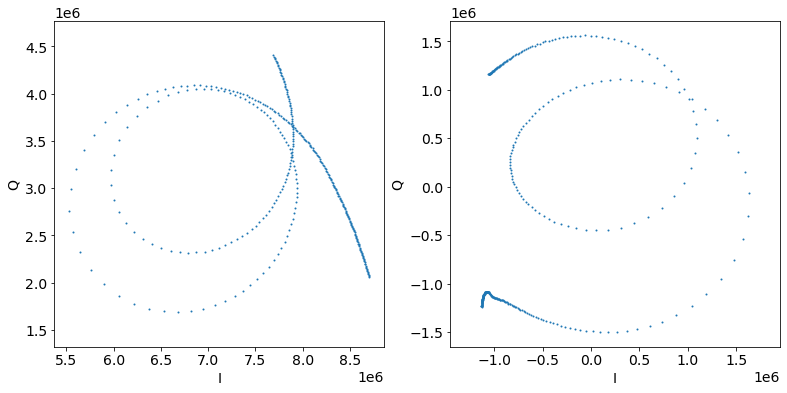

In [66]:
# Kept as holdover from prev nb, in case want to look in depth at the IQ
i=6

# Plot
fig,axs = plt.subplots(1,2,figsize=(13,6))

axs[0].plot(np.real(sw_iq_in[i]),np.imag(sw_iq_in[i]),'.',markersize=2) # raw sweep iq
axs[1].plot(np.real(sw_iq[i]),np.imag(sw_iq[i]),'.',markersize=2) # processed



#axs[0].plot(np.real(ts_iq[i]),np.imag(ts_iq[i]),'.',markersize=.2) # ts iq
#axs[1].plot(np.real(iq[i]),np.imag(iq[i]),'.',markersize=.2)

for ax in axs:
    ax.axis('equal')
    ax.set_xlabel('I')
    ax.set_ylabel('Q')

plt.show()

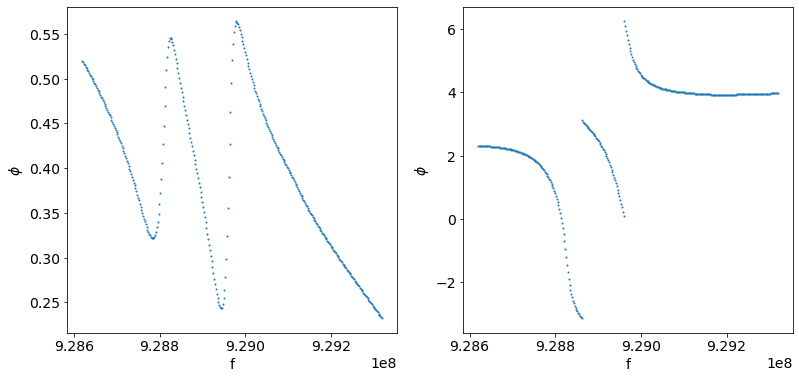

In [70]:
# Look at the phase(f) of the sweeps
i=6

# Plot
fig,axs = plt.subplots(1,2,figsize=(13,6))

y0 = np.arctan2(np.imag(sw_iq_in[i]),np.real(sw_iq_in[i]))
y1 = iq2df.unwrap(np.arctan2(np.imag(sw_iq),np.real(sw_iq)))[i]
      # processed and unwrapped to see what is being interpolated to.


axs[0].plot(freq[i],y0,'.',markersize=2) # raw sweep phase(f)
axs[1].plot(freq[i],y1,'.',markersize=2) # processed

for ax in axs:
    ax.set_xlabel('f')
    ax.set_ylabel('$\phi$')


plt.show()

In [49]:
print(freq)

[8.84783917e+08 8.95389774e+08 9.03153046e+08 9.15999878e+08
 9.26393840e+08 9.28816687e+08 9.28969617e+08 9.61057164e+08
 9.64018803e+08 9.76074938e+08 9.77858085e+08 9.88492973e+08
 9.93677469e+08 1.00337680e+09]
